In [26]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import os
import json
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import statsmodels.api as sm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from bprime.utils import index_cols
from bprime.sim_utils import read_params
from bprime.plots import surface_plot
from bprime.learn import LearnedFunction
from bprime.theory import bgs_segment, bgs_rec

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [28]:
lowess = sm.nonparametric.lowess

In [29]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [30]:
def log_tick_formatter(val, pos=None):
    return f"$10^{{{np.round(val, 1)}}}$"

## Data

In [31]:
with open('../slim_sims/training/fullbgs.json') as f:
    sim_config = json.load(f)
sim_params = read_params(sim_config)
sim_params

{'N': (1000, 1000, False),
 'mu': (5.5e-09, 1e-05, False),
 's': (-5.0, -1.0, True),
 'h': (0.5, 0.5, False),
 'rf': (-8.0, -0.301, True),
 'rbp': (1e-09, 5e-07, False),
 'L': (1, 1000, False)}

In [32]:
sim_data = np.load('../data/slim_sims/fullbgs_data.npz', allow_pickle=True)

In [33]:
Xcols = index_cols(sim_data['features'])
ycols = index_cols(sim_data['targets'])
sim_data['features'], sim_data['targets']

(array(['N', 'sh', 'mu', 'rf', 'rbp', 'L'], dtype='<U3'),
 array(['pi', 'Bhat', 'Ef', 'Vf', 'load'], dtype='<U4'))

In [34]:
assert len(sim_data['features']) == sim_data['X'].shape[1]

In [35]:
Xo, yo = np.array(sim_data['X']), sim_data['y']
Xo.shape, yo.shape

((213741, 6), (213741, 5))

In [36]:
# make sure we only have one population size
assert len(np.unique(Xo[:, Xcols('N')])) == 1

To be aligned with classic BGS theory, let's parameterize the heterozygous effect as $sh$. We build up our training dataset:

In [37]:
X_columns = ('sh', 'mu', 'rf', 'rbp', 'L')
X = Xo[:, Xcols(*X_columns)]
X, X.shape

(array([[1.0350e-04, 1.1470e-06, 5.8190e-05, 1.6110e-07, 7.0000e+02],
        [1.1035e-03, 2.1400e-06, 1.5220e-05, 1.6710e-07, 6.6000e+01],
        [1.3825e-05, 2.0390e-06, 1.0950e-01, 7.9400e-08, 1.1200e+02],
        ...,
        [1.9200e-05, 2.7320e-06, 2.2270e-04, 3.2630e-07, 6.4500e+02],
        [9.4800e-04, 9.2120e-06, 2.3170e-01, 2.2020e-07, 1.1900e+02],
        [6.2300e-03, 8.5360e-06, 1.6110e-07, 8.7420e-08, 4.8000e+01]]),
 (213741, 5))

Now extract the target, $\hat{B}$.

In [38]:
y = yo[:, ycols('Bhat')]

Use the `LearnedFunction` class to store data, etc.

In [39]:
sim_params

{'N': (1000, 1000, False),
 'mu': (5.5e-09, 1e-05, False),
 's': (-5.0, -1.0, True),
 'h': (0.5, 0.5, False),
 'rf': (-8.0, -0.301, True),
 'rbp': (1e-09, 5e-07, False),
 'L': (1, 1000, False)}

In [40]:
# h is fixed
assert sim_params['h'][0] == sim_params['h'][1]
h = sim_params['h'][0]

# rescale s bounds since we model sh
sh_domain = lambda l, u, _, h: (np.round(np.log10((10**l)*h), 3), np.round(np.log10((10**u)*h), 3), True)

domain = {'sh': sh_domain(*sim_params['s'], h)}
domain = {**domain, **{k: v for k, v in sim_params.items() if k in X_columns}}


func = LearnedFunction(X, y, domain=domain)
func

LearnedFunction with 5 feature(s) and 1 target(s)
 feature(s):
  - sh ∈ [-5.3, -1.3] (log10, None)
  - mu ∈ [5.5e-09, 1e-05] (linear, None)
  - rf ∈ [-8.0, -0.301] (log10, None)
  - rbp ∈ [1e-09, 5e-07] (linear, None)
  - L ∈ [1, 1000] (linear, None)
Features normalized? False
Features split? False

In [41]:
func.split(random_state=6)

LearnedFunction with 5 feature(s) and 1 target(s)
 feature(s):
  - sh ∈ [-5.3, -1.3] (log10, None)
  - mu ∈ [5.5e-09, 1e-05] (linear, None)
  - rf ∈ [-8.0, -0.301] (log10, None)
  - rbp ∈ [1e-09, 5e-07] (linear, None)
  - L ∈ [1, 1000] (linear, None)
Features normalized? False
Features split? True, test size: 10.0%

In [42]:
func.X_train.shape

(192366, 5)

In [43]:
#feature_transforms = {'mu': np.log10, 's': np.log10, 'recfrac': np.log10}
feature_transforms = {'mu': None, 'sh': np.log10, 'rf': np.log10}
feature_transforms = 'match'
func.scale_features(transforms = feature_transforms)

LearnedFunction with 5 feature(s) and 1 target(s)
 feature(s):
  - sh ∈ [-5.3, -1.3] (log10, <ufunc 'log10'>)
  - mu ∈ [5.5e-09, 1e-05] (linear, None)
  - rf ∈ [-8.0, -0.301] (log10, <ufunc 'log10'>)
  - rbp ∈ [1e-09, 5e-07] (linear, None)
  - L ∈ [1, 1000] (linear, None)
Features normalized? True
Features split? True, test size: 10.0%

In [44]:
def network(n64=4, n32=2, output_activation='sigmoid'):
    # build network
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(5,)))
    for i in range(n64):
        model.add(layers.Dense(64, activation='elu'))
    for i in range(n32):
        model.add(layers.Dense(32, activation='elu'))
    model.add(tf.keras.layers.Dense(1, activation=output_activation))
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanAbsoluteError'],
        )
    return model

In [45]:
force = True
model_file = '../data/dnn_models/fullbgs.h5'
if force or not os.path.exists(model_file):
    model = network(output_activation='sigmoid')
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                       patience=50, restore_best_weights=True)
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

    history = model.fit(func.X_train, func.y_train, 
                        validation_split=0.2, 
                        #validation_data=(X_test_normalized, y_test),
                        batch_size=64, epochs=200, verbose=0, callbacks=[es, tqdm_callback])
    model.save(model_file)
else:
    model = keras.models.load_model(model_file)

Training:   0%|                                                                                               …

Restoring model weights from the end of the best epoch: 22.
Epoch 00072: early stopping


In [49]:
func.model = model
func.save('../data/dnn_models/fullbgs')

In [21]:
%%time
class random_generator():
    def __init__(self, n):
        self.n = n
        self.i = 0
    def __iter__(self):
        return self
    def __next__(self):
        if self.i >= self.n:
            raise StopIteration
        self.i += 1
        return np.random.uniform(0, 1, (10_000, 5))
        
a = model.predict(random_generator(10_000), workers=10)

CPU times: user 54.8 s, sys: 5.93 s, total: 1min
Wall time: 33.8 s


In [25]:
a.shape, 10_000 **2

((100010000, 1), 100000000)

In [31]:
predict = func.predict_test(verbose=1)
np.mean((predict - func.y_test)**2)

668/668 [==============================] - 1s 911us/step


0.21822780833041852

In [ ]:
%%timeit
# how fast is prediction?
_ = func.predict_train(workers=70, use_multiprocessing=True)

In [ ]:
idx = np.abs(predict - 1) < 0.1
((predict[idx] - func.y_test[idx])**2).mean()

In [ ]:
predict.max()

In [ ]:
func.features

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


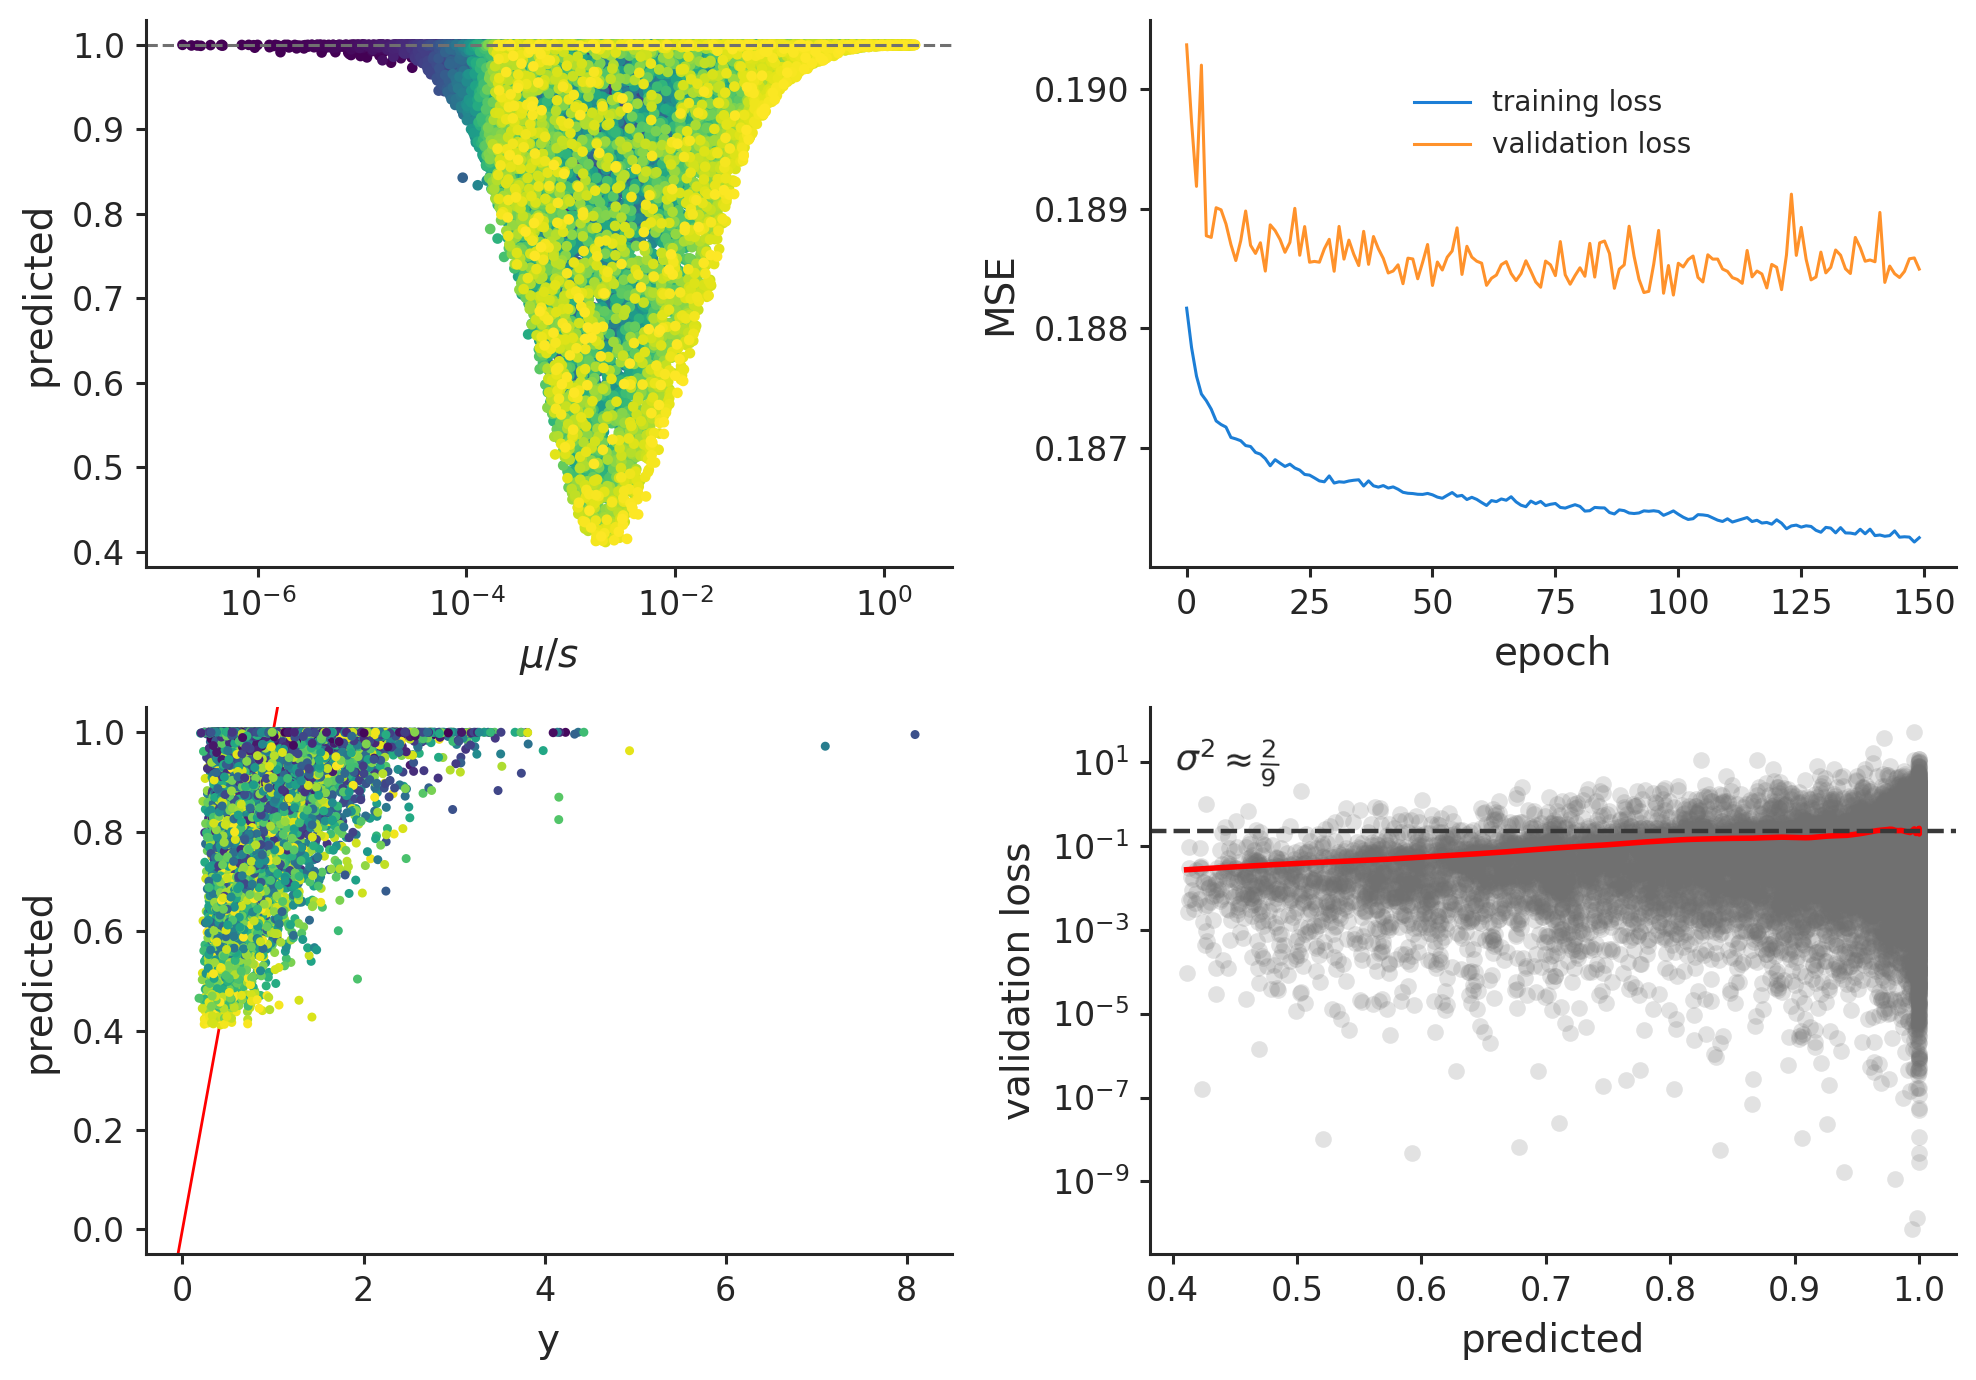

In [25]:
#y_theory = bgs_rec(func.X_test_orig[:, 0], func.X_test_orig[:, 1], func.X_test_orig[:, 2], 1000)

s_test, mu_test, rbp_test, rf_test, L_test = func.X_test_orig.T
rate = mu_test/10**s_test

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))

norm = plt.Normalize(np.min(mu_test), np.max(mu_test))

idx = np.argsort(mu_test)

ax1.scatter(rate[idx], predict[idx], c=mu_test[idx], cmap='viridis', s=8)
ax1.set_xlabel("$\mu/s$")
ax1.set_ylabel("predicted")
ax1.axhline(1, c='0.44', linestyle='dashed')
ax1.semilogx()
#cax1 = fig.add_axes([0.27, 0.8, 0.5, 0.05])
#fig.colorbar(cmap=cm.viridis, cax=cax1, orientation='horizontal')

#n = 10
#yedges = np.linspace(y_test.min(), y_test.max(), n)
#xedges = np.linspace(predict.min(), predict.max(), n)
#H, xedges, yedges = np.histogram2d(y_test.squeeze(), predict, bins=(xedges, yedges))
#X, Y = np.meshgrid(xedges, yedges)
#ax3.pcolormesh(X, Y, H)
ax3.scatter(func.y_test, predict, c=func.X_test[:, 1], s=5)
ax3.axline((0, 0), slope=1, c='r', linewidth=1, zorder=0)
ax3.set_xlabel('y')
ax3.set_ylabel('predicted')

ly = (predict - func.y_test.squeeze())**2
lX = predict
ax4.scatter(lX, ly, color='0.44', 
            linewidth=0, edgecolor='black', alpha=0.2)
#ax4.set_ylim(-0.1, 3)
z = lowess(ly, lX, frac= 1/10, it=0)
ax4.plot(z[:, 0], z[:, 1], c='r', linewidth=2)

# the lowess fit was sensitive to it=0; this shows that the it=0 
# case is nearly identical to OLS, e.g. right thing to do
#mod = sm.OLS(ly, sm.add_constant(lX))
#res = mod.fit()
#lX_new = sm.add_constant(np.linspace(0.4, 1, 100))
#ax4.plot(lX_new, res.predict(lX_new), c='g')

xnew = np.linspace(0.4, 1, 100)
def B_var_limit(B, N, mu=1):
    return (3*mu + 8*B*N*mu**2)/(36*B*N)
ax4.axhline(B_var_limit(1, 1000), c='0.22', linewidth=1.6, linestyle='dashed') # Note the 1/2 factor — see sim_power.ipynb! TODO
#ax4.text(0.03, 0.88, "$\sigma^2 = \\frac{3 \mu + 8 B N \mu}{36 B N}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.text(0.03, 0.88, "$\sigma^2 \\approx \\frac{2}{9}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.semilogy()
ax4.set_ylabel('validation loss')
ax4.set_xlabel('predicted')

ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

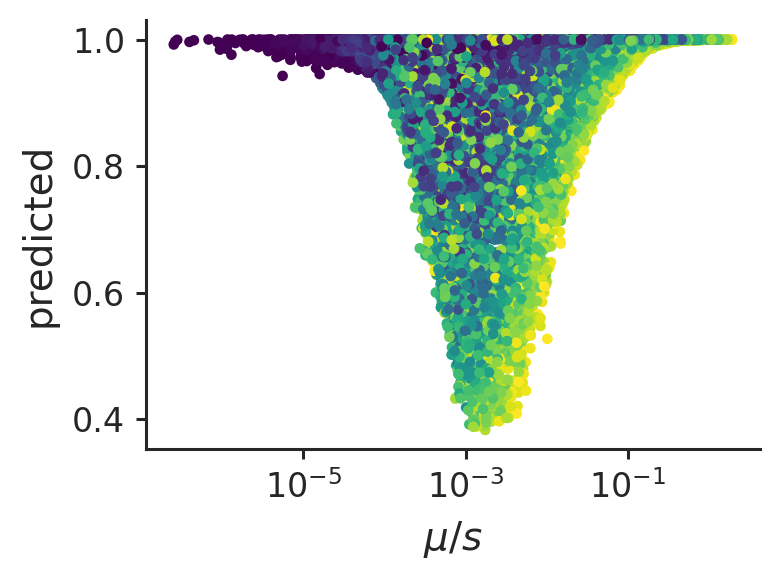

In [88]:
fig, ax  = plt.subplots(figsize=(4, 3))

ax.scatter(rate, predict, c=mu_test, cmap='viridis', s=8)
ax.set_xlabel("$\mu/s$")
ax.set_ylabel("predicted")
ax.semilogx()

plt.tight_layout()

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


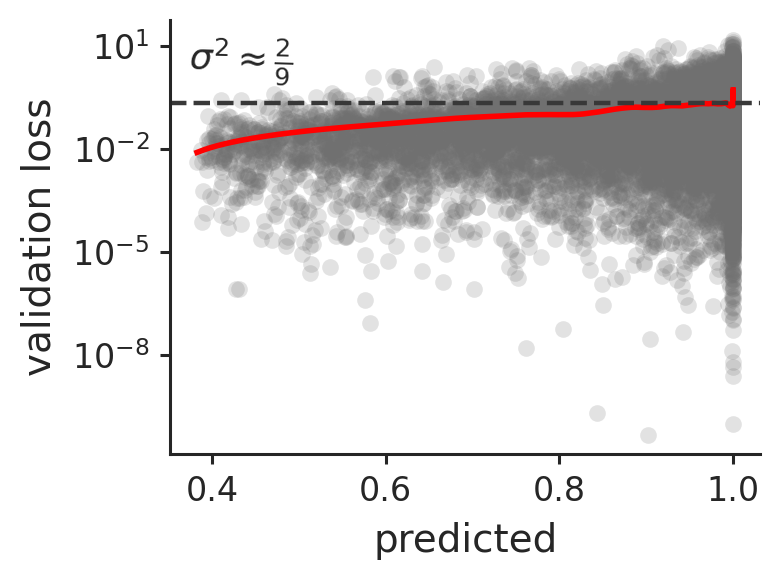

In [89]:
fig, ax  = plt.subplots(figsize=(4, 3))
ly = (predict - func.y_test.squeeze())**2
lX = predict
ax.scatter(lX, ly, color='0.44', 
            linewidth=0, edgecolor='black', alpha=0.2)
#ax4.set_ylim(-0.1, 3)
z = lowess(ly, lX, frac= 1/10, it=0)
ax.plot(z[:, 0], z[:, 1], c='r', linewidth=2)

ax.axhline(B_var_limit(1, 1000), c='0.22', linewidth=1.6, linestyle='dashed') # Note the 1/2 factor — see sim_power.ipynb! TODO
#ax4.text(0.03, 0.88, "$\sigma^2 = \\frac{3 \mu + 8 B N \mu}{36 B N}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax.text(0.03, 0.88, "$\sigma^2 \\approx \\frac{2}{9}$", size=13, rotation=-1.5, transform=ax.transAxes)
ax.semilogy()
ax.set_ylabel('validation loss')
ax.set_xlabel('predicted')
plt.tight_layout()
fig.savefig('/home/vsb/val_loss.pdf')

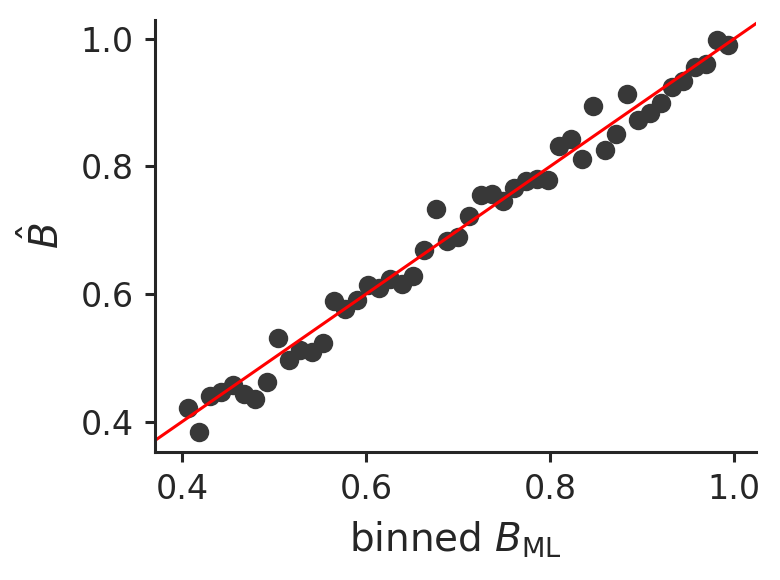

In [26]:
bins = np.linspace(0.4, 1, 50)
ytest_bins = stats.binned_statistic(predict, func.y_test.squeeze(), bins=bins)
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(0.5*(bins[1:] + bins[:-1]), ytest_bins.statistic, c='0.22')
ax.set_ylabel('$\hat{B}$')
ax.set_xlabel('binned $B_\mathrm{ML}$')
ax.axline((0.4, 0.4), slope=1, c='r')
plt.tight_layout()


In [37]:
# Note that the training data does not log10 mu, but here we do (otherwise the grid looks
# like chunky peanut butter).
(s_grid, mu_grid, *_), X_mesh_orig, X_mesh, predict_grid = func.predict_grid({'mu': 101, 'sh': 100}, 
                                                                            fix_X={'rf': np.log10(1e-8),
                                                                                   'rbp': 1e-8,
                                                                                    'L': 1_000},
                                                                            log10=('mu', ))

making 101x100 grid...	done.
316/316 [==============================] - 0s 1ms/step


In [38]:
func.features

{'sh': 0, 'mu': 1, 'rbp': 2, 'rf': 3, 'L': 4}

In [39]:
X_mesh_orig

array([[-5.30100000e+00,  5.50000000e-09,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03],
       [-5.26059596e+00,  5.50000000e-09,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03],
       [-5.22019192e+00,  5.50000000e-09,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03],
       ...,
       [-1.38180808e+00,  1.00000000e-05,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03],
       [-1.34140404e+00,  1.00000000e-05,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03],
       [-1.30100000e+00,  1.00000000e-05,  1.00000000e-08,
        -8.00000000e+00,  1.00000000e+03]])

In [40]:
ncontour = np.linspace(0.4, 0.96, 8)

Z = bgs_segment(X_mesh_orig[:, 1], 10**X_mesh_orig[:, 0], 10**X_mesh_orig[:, 3], X_mesh_orig[:, 2],  X_mesh_orig[:, 4]).reshape(predict_grid.shape).squeeze().T
Zp = predict_grid.squeeze().T

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


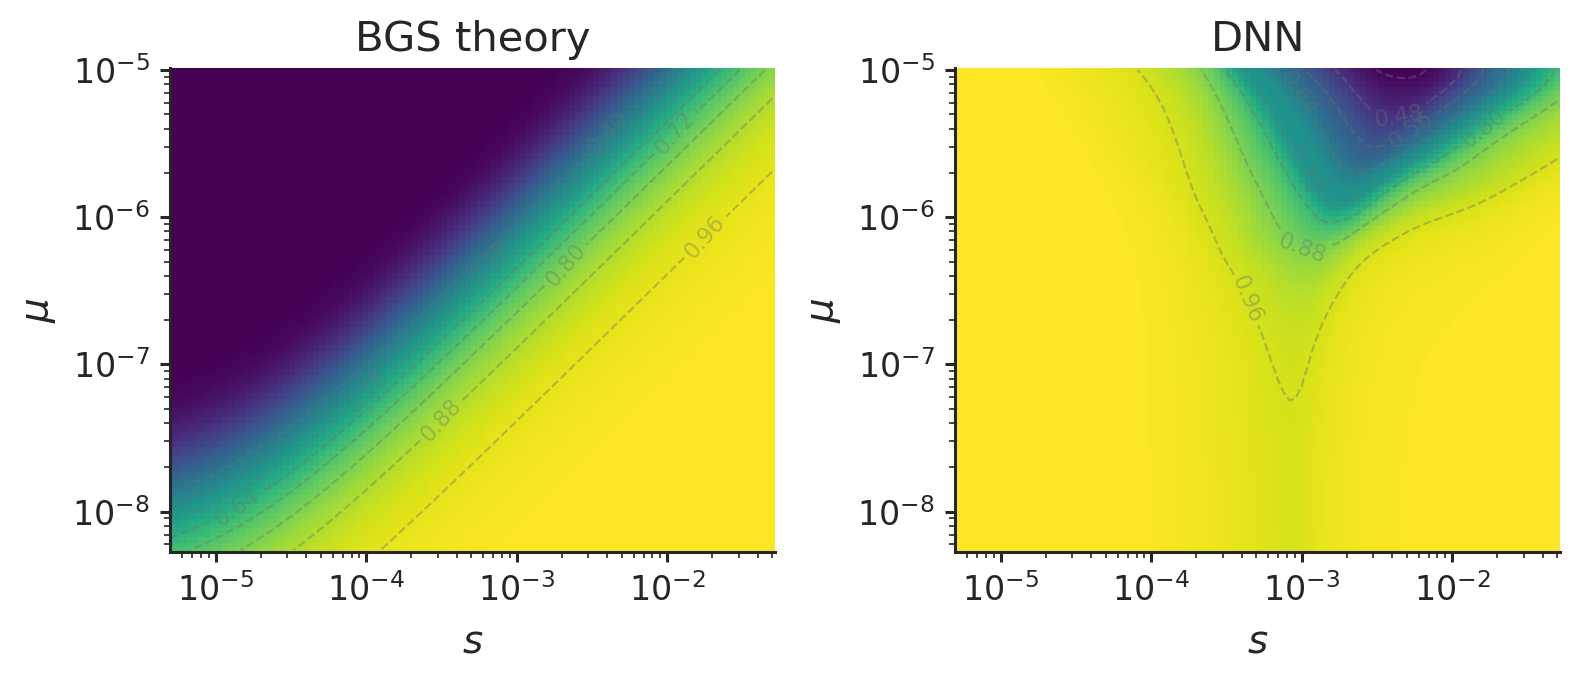

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z.T, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp.T, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

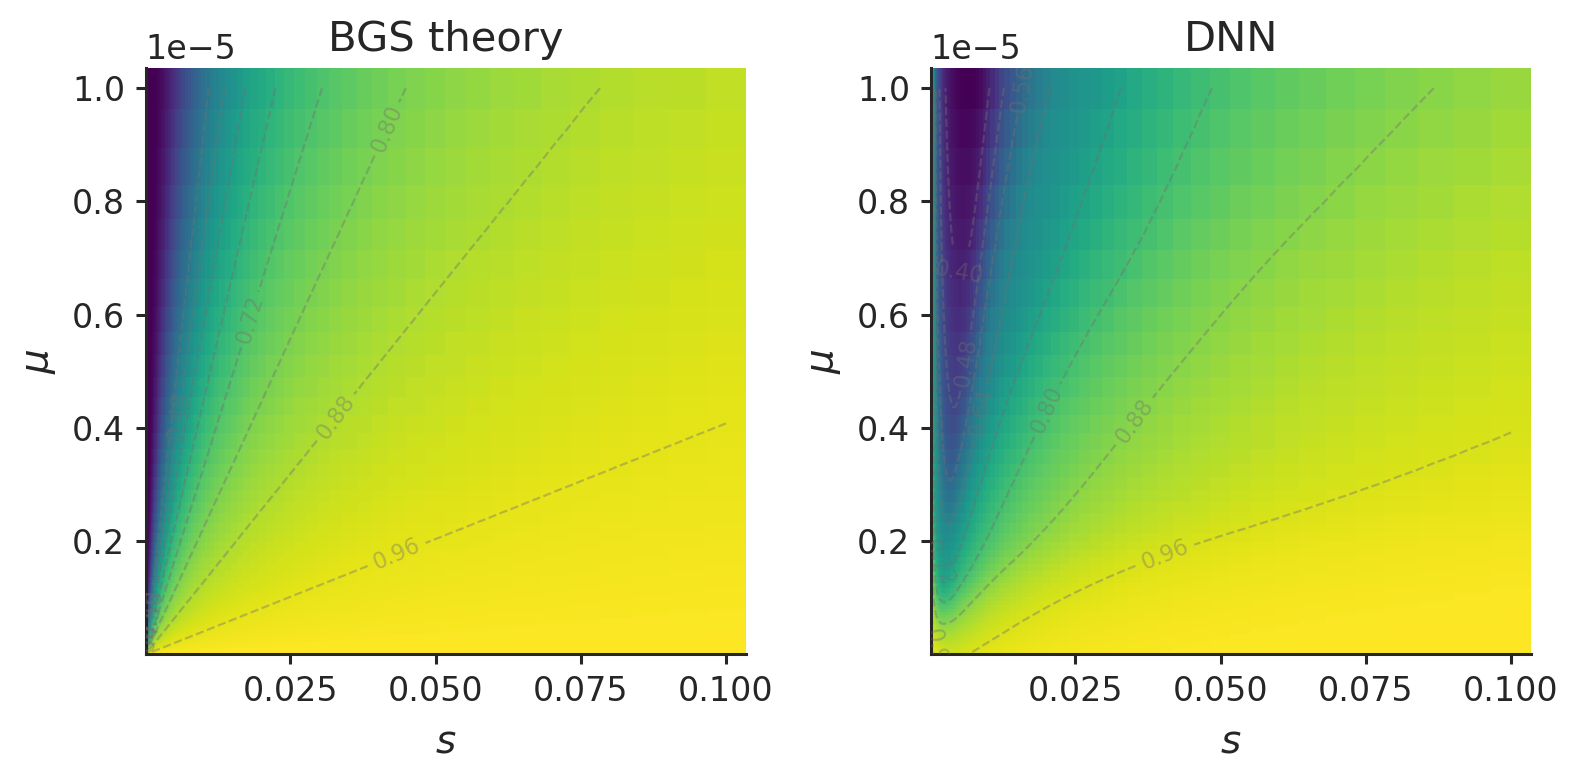

In [51]:
fig, ax = plt.subplots(ncols=2)
surface_plot(s_grid, mu_grid, Z, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

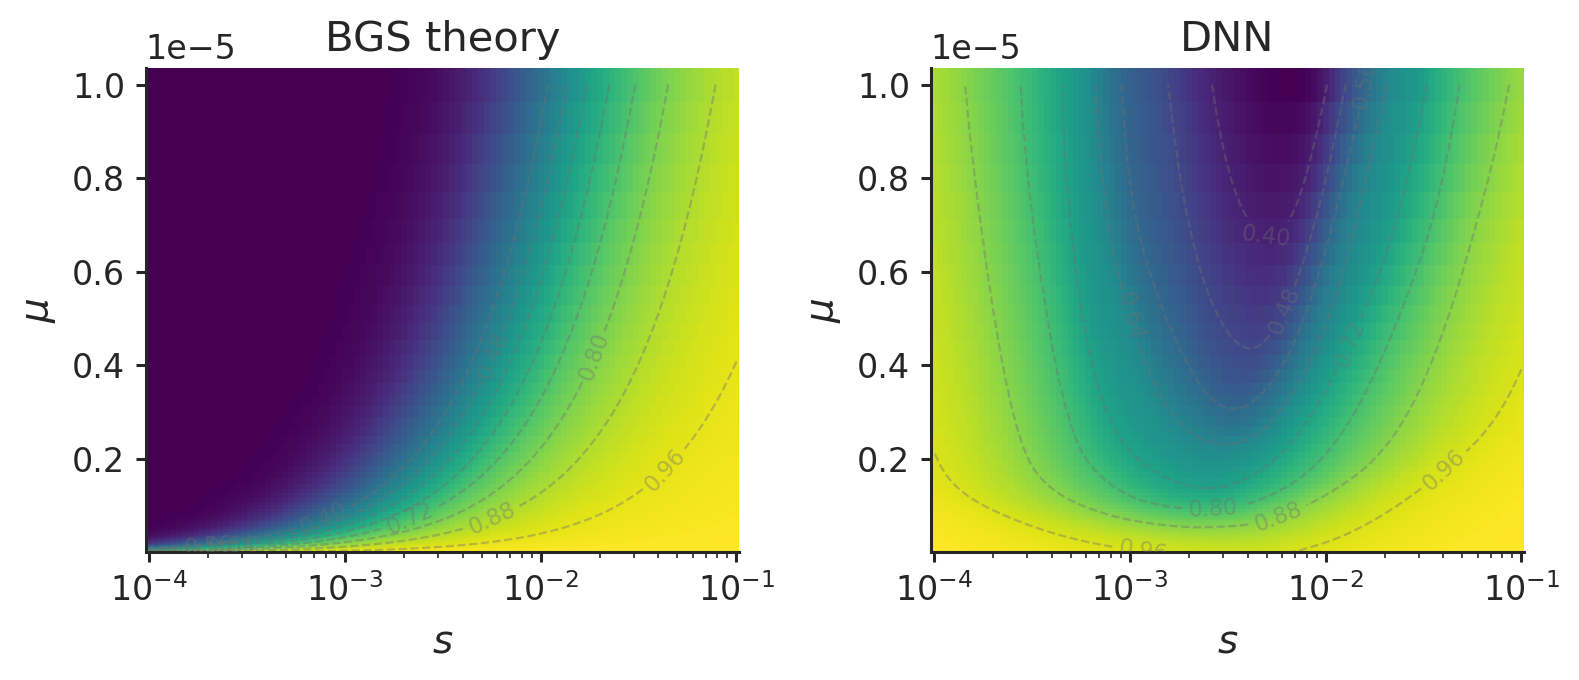

In [52]:

fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
surface_plot(s_grid, mu_grid, Z, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout() 
fig.savefig('/home/vsb/B_surface.pdf')

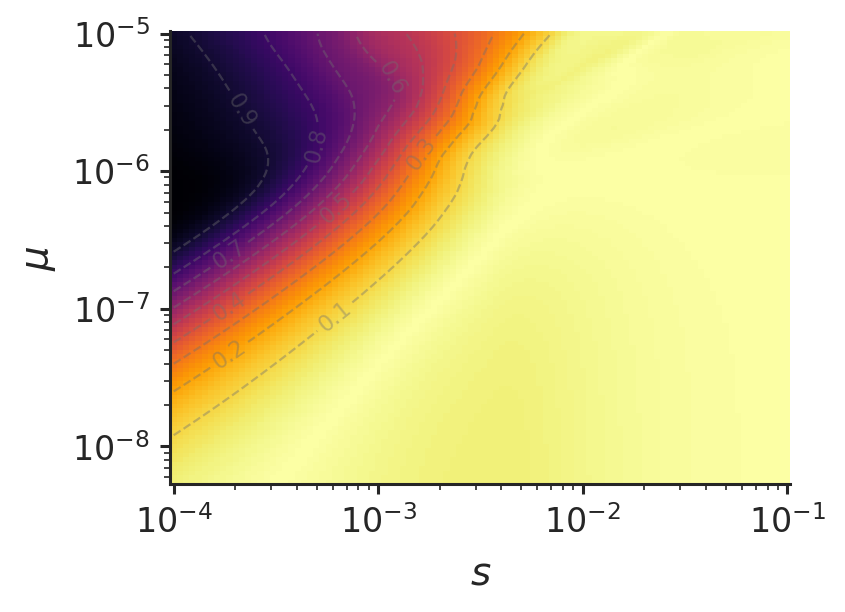

In [53]:
Zdiff = np.abs(Z-Zp)
figax = plt.subplots(figsize=(4, 3))
surface_plot(s_grid, mu_grid, Zdiff, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=10, cmap='inferno_r', figax=figax)
fig.savefig('/home/vsb/error_surface.pdf')

### Interpolation

In [28]:
20**2 * 50**2 * 40 / 1e6

40.0

In [33]:
# Note that the training data does not log10 mu, but here we do 
(s_grid, mu_grid, rf_grid, rbp_grid, L_grid), X_mesh_orig, X_mesh, predict_grid = func.predict_grid({'mu': 20, 'sh': 20, 'rf': 50, 'rbp': 40, 'L': 50})

{'sh', 'L', 'mu', 'rbp', 'rf'}
making 20 x 20 x 50 x 40 x 50 grid...	done.
1250000/1250000 [==============================] - 1570s 1ms/step


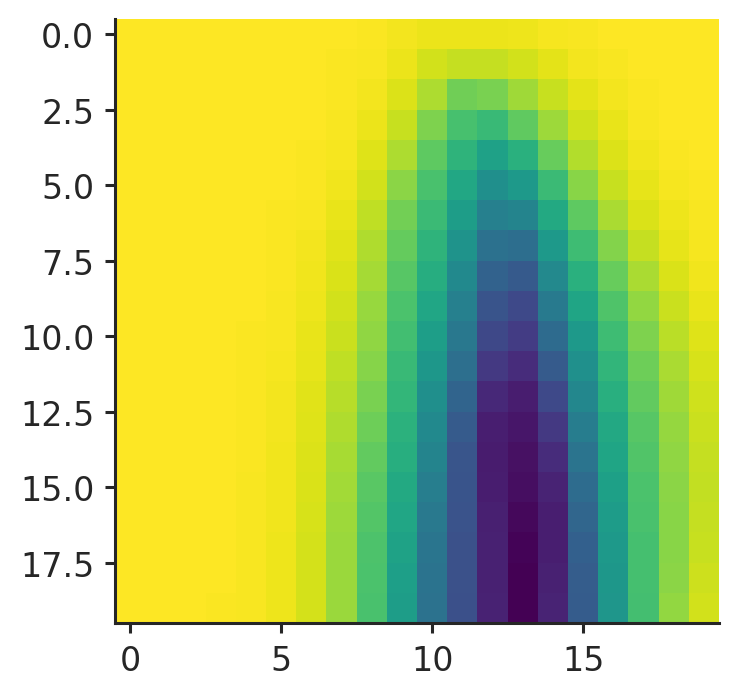

In [36]:
plt.imshow(predict_grid[:, :, 0, 10, 10])

In [39]:
# Note that the training data does not log10 mu, but here we do (otherwise the grid looks
# like chunky peanut butter).
(mu_grid_rbp, s_grid_rbp, a, b, c), X_mesh_orig_rbp, X_mesh_rbp, predict_grid_rbp = func.predict_grid({'rf': 100},
                                                                            fix_X={'mu': 1e-5, 
                                                                                   'sh': 0.1,
                                                                                   'rbp': 1e-8,
                                                                                    'L': 1_000},
                                                                            )

{'mu', 'sh', 'rf', 'L', 'rbp'}


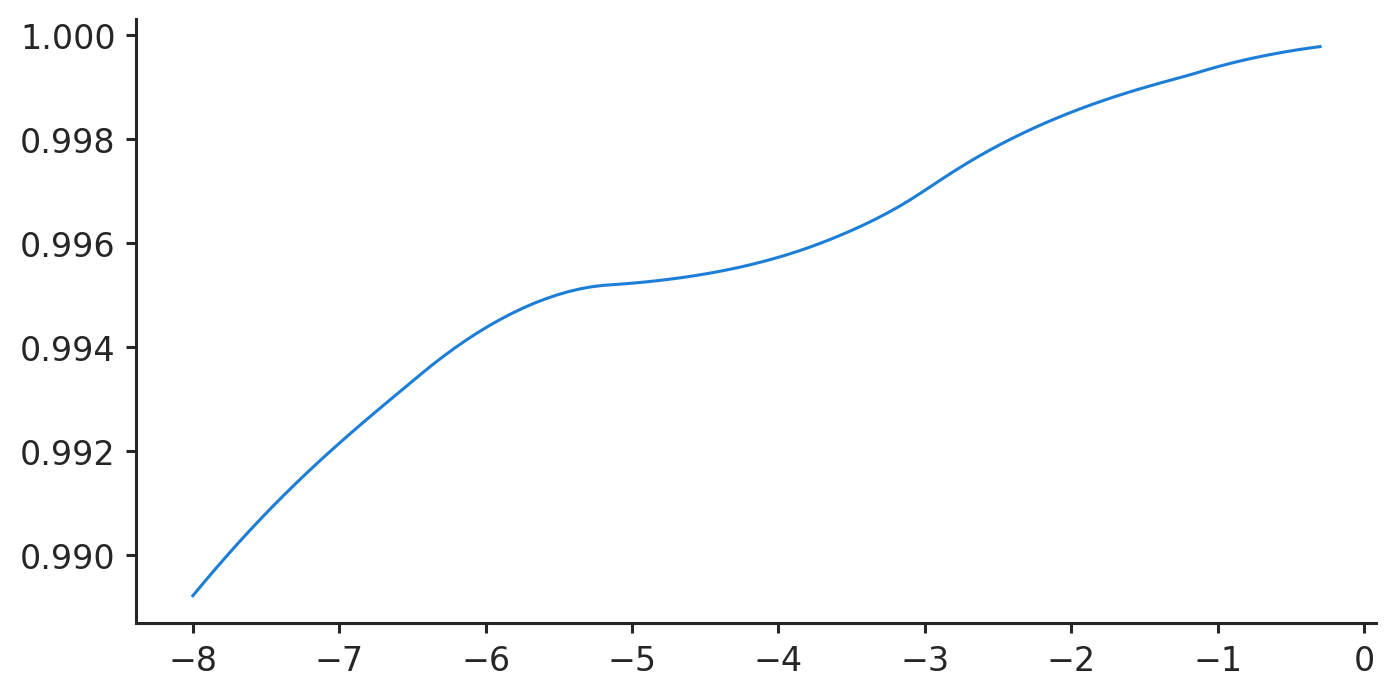

In [44]:
plt.plot(np.log10(b), predict_grid_rbp.squeeze())

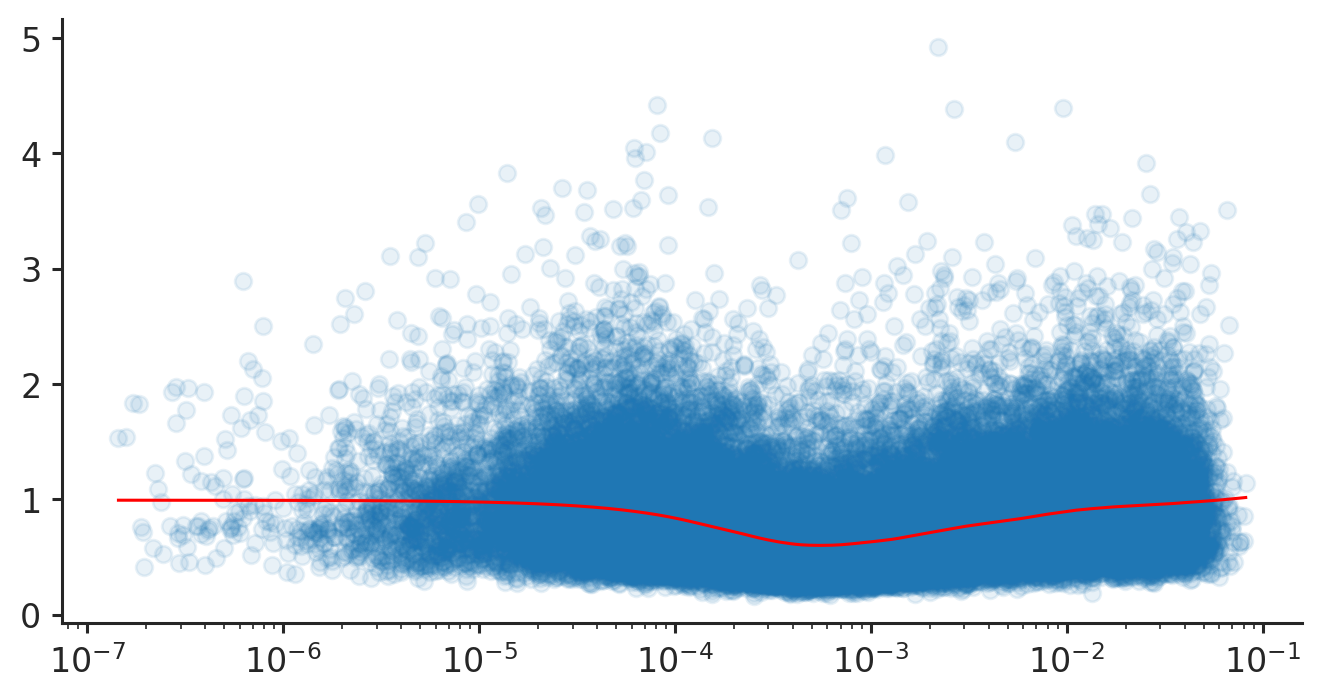

In [240]:
idx = Xo[:, 4] < 1
rate = Xo[idx, 3]/Xo[idx, 1]
yy = yo[idx, 1]
fig, ax = plt.subplots()
ax.scatter(rate, yy, alpha=0.1)

z = lowess(yy, rate, frac= 1./3, it=0)
ax.plot(z[:, 0], z[:, 1], c='r')
ax.set_xscale('log')

- make a kernel ridge vs DNN predicted surface plot
- weak impact on B can be caused by both BGS and weak selection
- is the mulitplicative right?


In [241]:
X.shape, y.shape


((57783, 3), (57783, 1))

/tmp/ipykernel_1377/1219890557.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_xticks()])


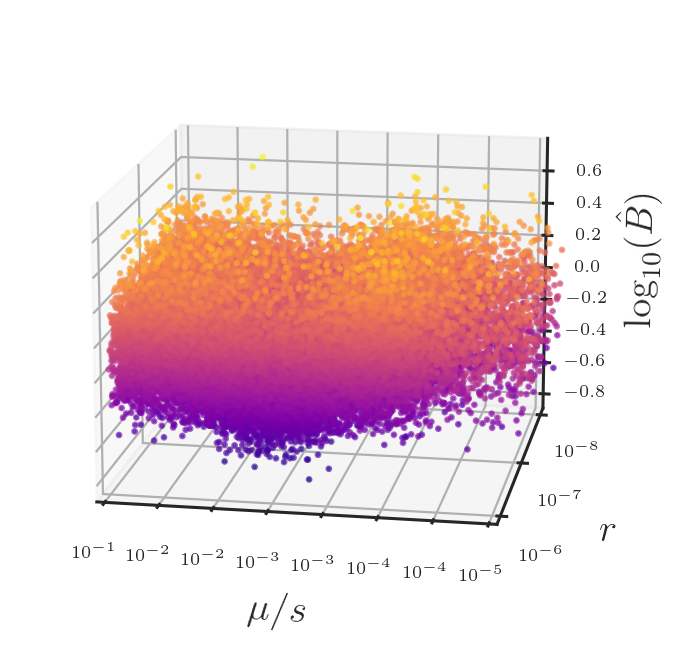

In [323]:
plt.rcParams['text.usetex'] = True

fig = plt.figure()
ax = plt.axes(projection='3d')

idx = (np.log10(X[:, 0]/X[:, 1]) > -5.3) & (np.log10(X[:, 0]/X[:, 1]) < -1.5)
Xtr = X[idx, :]
ax.scatter(np.log10(Xtr[:, 0]/Xtr[:, 1]), np.log10(Xtr[:, 2]), np.log10(y[idx]), s=2,
           c=np.log10(y[idx]), alpha=0.6, cmap='plasma')

#ax.view_init(5, 270)
ax.view_init(15, 100)
ax.set_xlim(-5, -1.5)
ax.set_xlabel('$\\mu/s$')
ax.set_ylabel('$r$')
ax.set_zlabel('$\\log_{10}(\\hat{B})$')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_xticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_xticks()])
ax.set_yticks(np.linspace(-8, -6, 3))
ax.set_yticklabels([f'$10^{{{int(x)}}}$' for x in ax.get_yticks()])
fig.savefig('/home/vsb/B3D.pdf')